In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from config.settings import settings
from scipy.stats import pearsonr

In [2]:
DATASETS_BASE = settings.MODULES_TO_DATASETS_PATH

In [3]:
df1_4 = pd.read_csv(DATASETS_BASE + settings.DATA_EU_AIR_F1_4, low_memory=False)

In [4]:
df1_4.info

<bound method DataFrame.info of            countryName  EPRTRSectorCode   
0              Austria              4.0  \
1              Austria              9.0   
2              Austria              6.0   
3              Austria              6.0   
4              Austria              3.0   
...                ...              ...   
324550  United Kingdom              8.0   
324551  United Kingdom              5.0   
324552  United Kingdom              5.0   
324553  United Kingdom              7.0   
324554  United Kingdom              7.0   

                                          eprtrSectorName   
0                                       Chemical industry  \
1                                        Other activities   
2                Paper and wood production and processing   
3                Paper and wood production and processing   
4                                        Mineral industry   
...                                                   ...   
324550  Animal and veget

In [5]:
df_pivoted = df1_4.pivot_table(index=['FacilityInspireID', 'reportingYear'],
                                columns='pollutant',
                                values='emissions',
                                aggfunc='sum').reset_index()

df_pivoted.reset_index(inplace=True)
df_pivoted.iloc[:, 3:] = df_pivoted.iloc[:, 3:].fillna(0)

In [6]:
df_unique = df1_4.drop_duplicates(subset=['FacilityInspireID', 'reportingYear']).drop(columns=['pollutant', 'emissions'])

In [7]:
df_final = pd.merge(df_unique, df_pivoted, on=['FacilityInspireID', 'reportingYear'], how='left')

# Dataset transformé
df_final = df_final.drop(columns=['index'])

In [8]:
df_final.info

<bound method DataFrame.info of            countryName  EPRTRSectorCode   
0              Austria              4.0  \
1              Austria              9.0   
2              Austria              6.0   
3              Austria              3.0   
4              Austria              9.0   
...                ...              ...   
179484  United Kingdom              1.0   
179485  United Kingdom              8.0   
179486  United Kingdom              5.0   
179487  United Kingdom              7.0   
179488  United Kingdom              7.0   

                                          eprtrSectorName   
0                                       Chemical industry  \
1                                        Other activities   
2                Paper and wood production and processing   
3                                        Mineral industry   
4                                        Other activities   
...                                                   ...   
179484                  

In [12]:
df_final.columns

Index(['countryName', 'EPRTRSectorCode', 'eprtrSectorName',
       'EPRTRAnnexIMainActivityCode', 'EPRTRAnnexIMainActivityLabel',
       'FacilityInspireID', 'facilityName',
       'facilityNameConfidentialityReason', 'Longitude', 'Latitude',
       'addressConfidentialityReason', 'City', 'targetRelease',
       'reportingYear', 'releasesConfidentialityReason',
       '1,1,1-trichloroethane (TCE-1,1,1)',
       '1,1,2,2-tetrachloroethane (TETRACHLOROETHANE-1,1,2,2)',
       '1,2,3,4,5,6-hexachlorocyclohexane (HCH)',
       '1,2-dichloroethane (DCE-1,2)', 'Aldrin', 'Ammonia (NH3)', 'Anthracene',
       'Arsenic and compounds (as As)', 'Asbestos', 'Benzene',
       'Benzo(g,h,i)perylene', 'Brominated diphenylethers (PBDE)',
       'CONFIDENTIAL', 'Cadmium and compounds (as Cd)', 'Carbon dioxide (CO2)',
       'Carbon dioxide (CO2) excluding biomass', 'Carbon monoxide (CO)',
       'Chlordecone', 'Chlorides (as total Cl)',
       'Chlorine and inorganic compounds (as HCl)',
       'Chloro

In [13]:
correlation_matrix = df_final.iloc[:, 15:].corr(method='pearson')

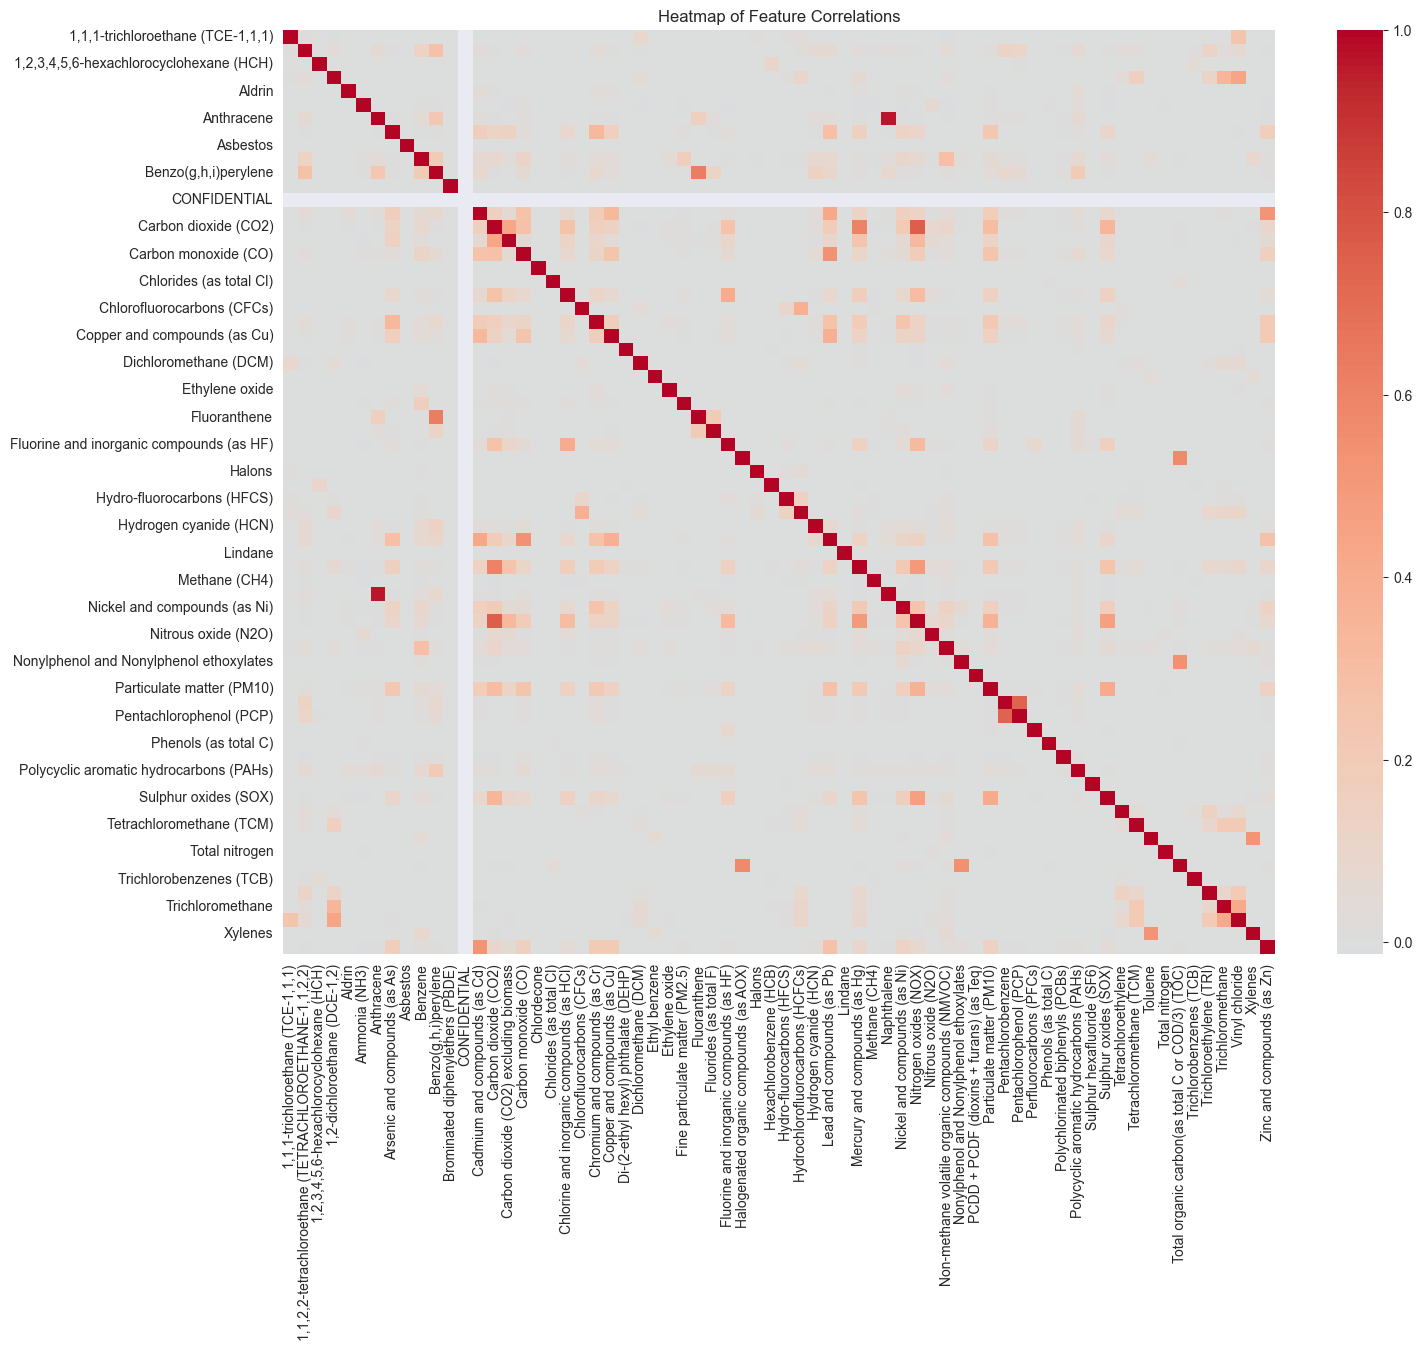

In [14]:
plt.figure(figsize=(16, 12))

heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)

plt.title('Heatmap of Feature Correlations')

plt.show()

In [15]:
threshold = 0.75  # This is an arbitrary threshold

high_correlations = np.where(np.abs(correlation_matrix) > threshold)

high_correlations = [(correlation_matrix.index[x], correlation_matrix.columns[y])
                     for x, y in zip(*high_correlations)
                     if x != y and x < y]

In [16]:
for pair in high_correlations:
    corr_value, p_value = pearsonr(df_final[pair[0]], df_final[pair[1]])
    print(f"Correlation between {pair[0]} and {pair[1]}: {corr_value}, P-value: {p_value}")

Correlation between Anthracene and Naphthalene: 0.9613208385860071, P-value: 0.0
Correlation between Carbon dioxide (CO2) and Nitrogen oxides (NOX): 0.7564119404282662, P-value: 0.0


In [36]:
# Création d'un dataset avec une ligne par entreprise et par an, avec comme feature les différents polluants

# Sélection des colonnes numériques pour l'agrégation, en excluant reportingYear
cols_to_agg = [col for col in df_final.select_dtypes(include=[np.number]).columns.tolist() if col != 'reportingYear']

# Regroupement et agrégation
df_agg_per_FacilityInspireID_per_year = df_final.groupby(['FacilityInspireID', 'reportingYear'])[cols_to_agg].mean().reset_index()

In [38]:
df_agg_per_FacilityInspireID_per_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179489 entries, 0 to 179488
Data columns (total 73 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   FacilityInspireID                                      179489 non-null  object 
 1   reportingYear                                          179489 non-null  int32  
 2   EPRTRSectorCode                                        178649 non-null  float64
 3   Longitude                                              179489 non-null  float64
 4   Latitude                                               179489 non-null  float64
 5   1,1,1-trichloroethane (TCE-1,1,1)                      179489 non-null  float64
 6   1,1,2,2-tetrachloroethane (TETRACHLOROETHANE-1,1,2,2)  179489 non-null  float64
 7   1,2,3,4,5,6-hexachlorocyclohexane (HCH)                179489 non-null  float64
 8   1,2-dichloroethane (DCE-1,2)      

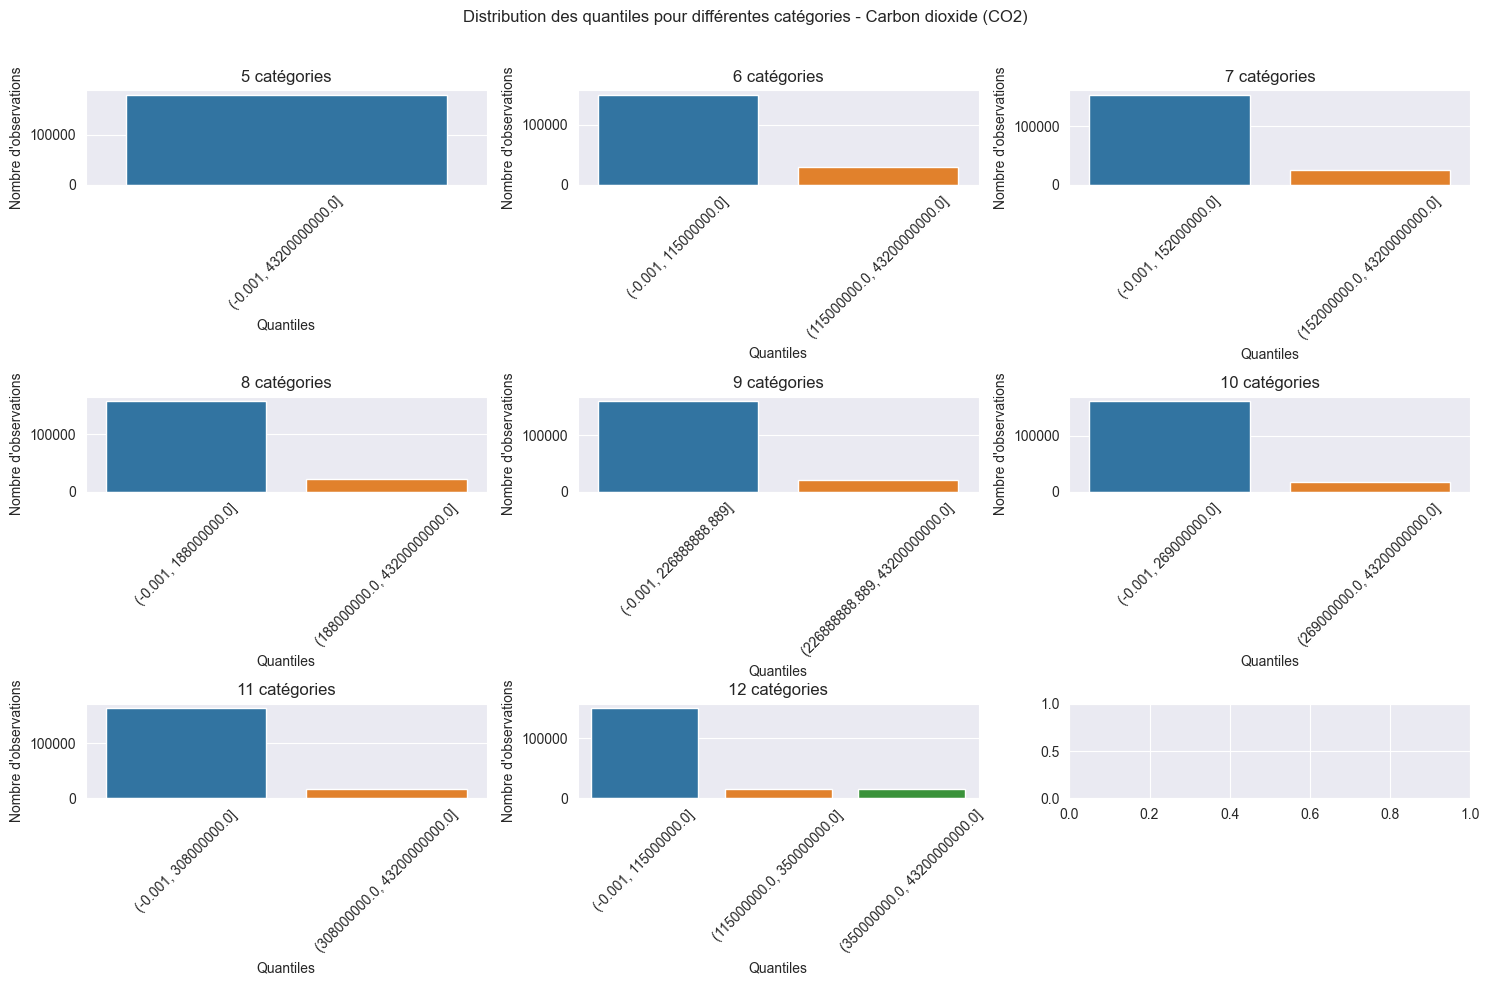

In [83]:
# Liste des nombres de quantiles à tester
quantile_counts = [5, 6, 7, 8, 9, 10, 11, 12]

# Sélection d'une colonne de polluant pour la visualisation
pollutant_col = 'Carbon dioxide (CO2)'

# Nombre de lignes et de colonnes pour les subplots
n_rows = 3
n_cols = 3

# Création de la figure et des axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.suptitle(f'Distribution des quantiles pour différentes catégories - {pollutant_col}')

# Parcours de chaque nombre de quantiles et création d'un graphique
for i, q in enumerate(quantile_counts):
    row = i // n_cols
    col = i % n_cols

    # Création des quantiles
    df_agg_per_FacilityInspireID_per_year['quantile'] = pd.qcut(df_agg_per_FacilityInspireID_per_year[pollutant_col], q=q, duplicates='drop')

    # Visualisation dans le subplot correspondant
    sns.countplot(x='quantile', data=df_agg_per_FacilityInspireID_per_year, ax=axes[row, col])
    axes[row, col].set_title(f'{q} catégories')
    axes[row, col].set_xlabel('Quantiles')
    axes[row, col].set_ylabel('Nombre d\'observations')
    axes[row, col].tick_params(axis='x', rotation=45)

# Ajustement des subplots pour éviter le chevauchement
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Ajustez en fonction de votre titre principal
plt.show()

Vu les graphiques de comparaison de pertinence des quantiles ci-dessus, nous allons partir sur 6 quantiles pour la labellisation.

In [118]:
# labels = ['A', 'B', 'C', 'D', 'E', 'F']
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

for col in cols_to_agg:
    try:
        df_agg_per_FacilityInspireID_per_year[col + '_label'] = pd.qcut(df_agg_per_FacilityInspireID_per_year[col],
                                                                       q=len(labels),
                                                                       labels=labels,
                                                                       duplicates='drop')
    except ValueError:
        # En cas de valeur unique ou insuffisante pour former les quantiles demandés
        # Assignation du même label (par exemple 'A') à toutes les observations
        df_agg_per_FacilityInspireID_per_year[col + '_label'] = pd.Series([labels[0]] * len(df_agg_per_FacilityInspireID_per_year),
                                                                         index=df_agg_per_FacilityInspireID_per_year.index)

# Conversion des labels en valeurs numériques pour calculer la moyenne
label_to_num = {label: i for i, label in enumerate(labels)}
num_cols = [col + '_label' for col in cols_to_agg]

df_agg_per_FacilityInspireID_per_year[num_cols] = df_agg_per_FacilityInspireID_per_year[num_cols].replace(label_to_num)

# Calcul de la moyenne des labels numériques par entreprise
df_agg_per_FacilityInspireID_per_year['average_label_num'] = df_agg_per_FacilityInspireID_per_year[num_cols].mean(axis=1)

# Définition des bords des bins avec np.histogram_bin_edges
bin_edges = np.histogram_bin_edges(df_agg_per_FacilityInspireID_per_year['average_label_num'], bins=len(labels))

# Vérification quant au fait que le nombre de bords est supérieur au nombre de labels de 1
if len(bin_edges) != len(labels) + 1:
    # Ajustement des bords des bins
    bin_edges = np.linspace(df_agg_per_FacilityInspireID_per_year['average_label_num'].min(),
                            df_agg_per_FacilityInspireID_per_year['average_label_num'].max(),
                            len(labels) + 1)

# Conversion de la moyenne numérique des labels en labels catégoriels
df_agg_per_FacilityInspireID_per_year['average_label'] = pd.cut(df_agg_per_FacilityInspireID_per_year['average_label_num'], bins=bin_edges, labels=labels, include_lowest=True)

In [129]:
df_agg_per_FacilityInspireID_per_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179489 entries, 0 to 179488
Columns: 147 entries, FacilityInspireID to average_label
dtypes: category(4), float64(72), int32(1), int64(69), object(1)
memory usage: 195.8+ MB


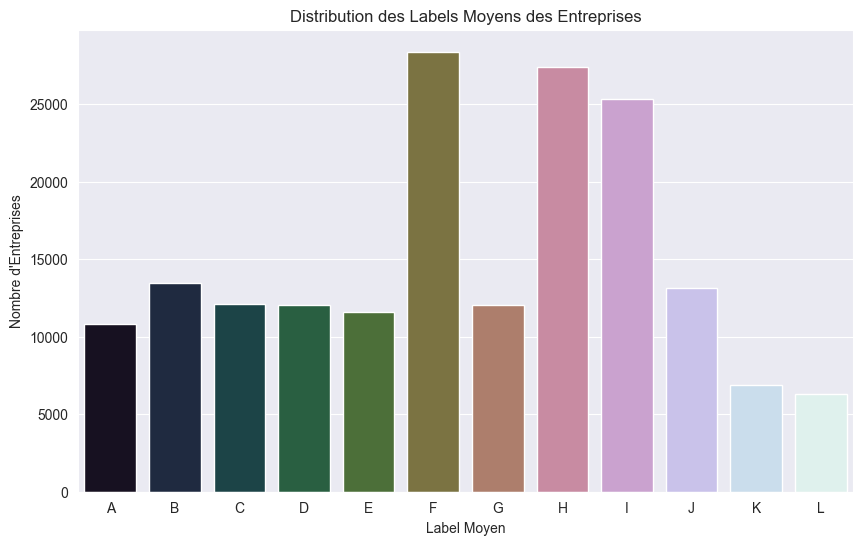

In [120]:
# Histogramme des labels moyens
plt.figure(figsize=(10, 6))
sns.countplot(x='average_label', data=df_agg_per_FacilityInspireID_per_year, palette='cubehelix')
plt.title('Distribution des Labels Moyens des Entreprises')
plt.xlabel('Label Moyen')
plt.ylabel('Nombre d\'Entreprises')
plt.show()

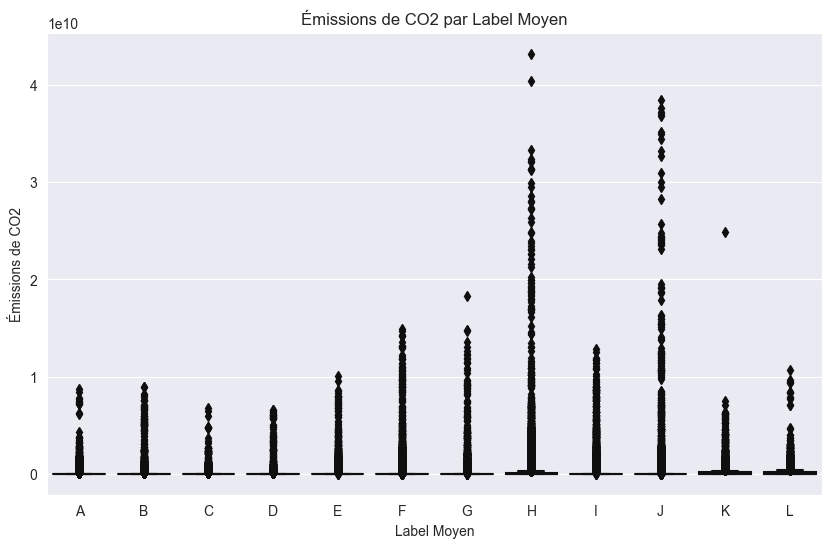

In [121]:
# Boxplot des émissions de CO2 pour chaque label moyen
plt.figure(figsize=(10, 6))
sns.boxplot(x='average_label', y='Carbon dioxide (CO2)', data=df_agg_per_FacilityInspireID_per_year, palette='cubehelix')
plt.title('Émissions de CO2 par Label Moyen')
plt.xlabel('Label Moyen')
plt.ylabel('Émissions de CO2')
plt.show()

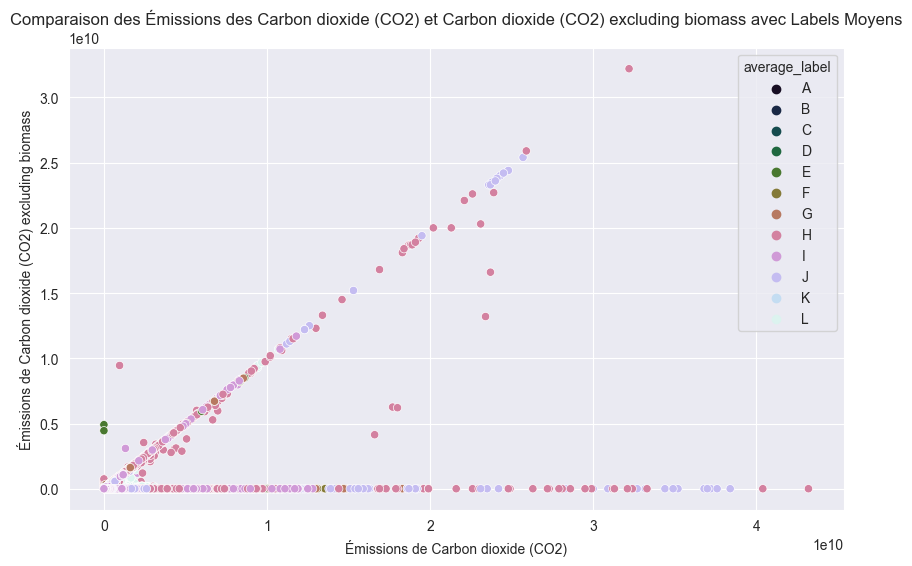

In [122]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Carbon dioxide (CO2)', y='Carbon dioxide (CO2) excluding biomass', hue='average_label', data=df_agg_per_FacilityInspireID_per_year, palette='cubehelix')
plt.title('Comparaison des Émissions des Carbon dioxide (CO2) et Carbon dioxide (CO2) excluding biomass avec Labels Moyens')
plt.xlabel('Émissions de Carbon dioxide (CO2)')
plt.ylabel('Émissions de Carbon dioxide (CO2) excluding biomass')
plt.show()

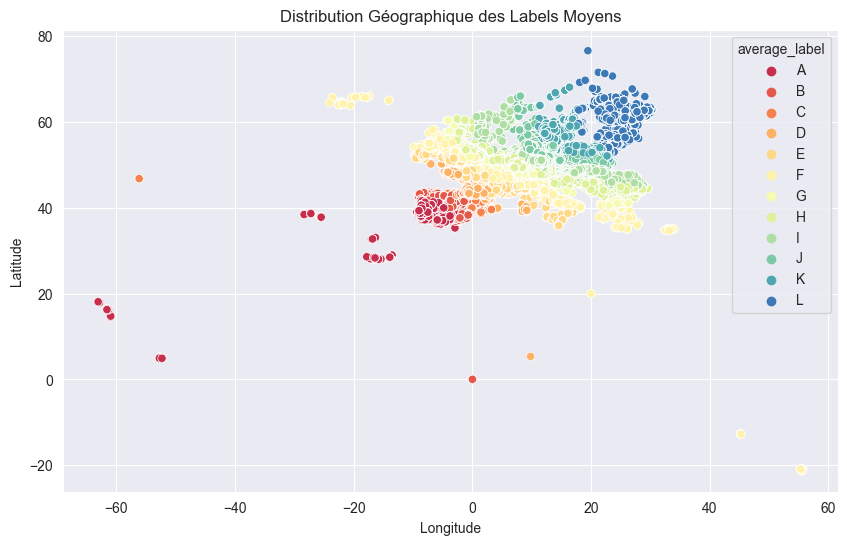

In [124]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Longitude', y='Latitude', hue='average_label', data=df_agg_per_FacilityInspireID_per_year, palette='Spectral')
plt.title('Distribution Géographique des Labels Moyens')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

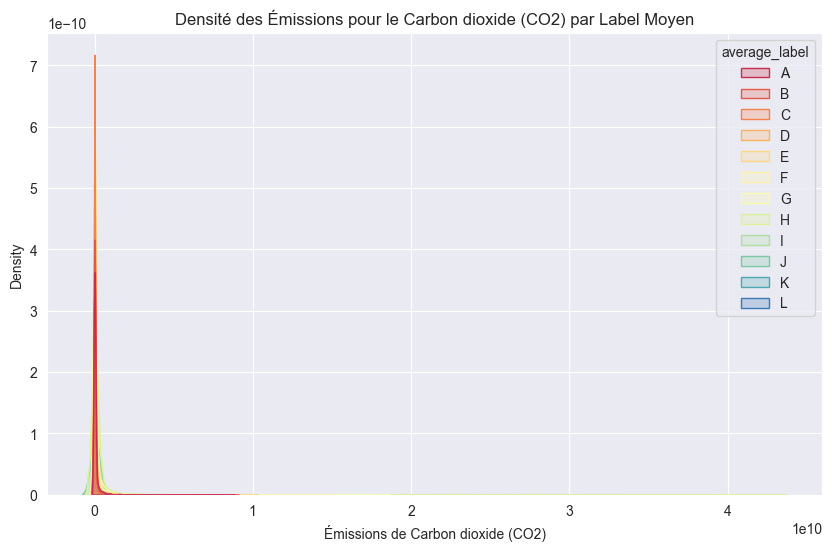

In [125]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x='Carbon dioxide (CO2)', hue='average_label', data=df_agg_per_FacilityInspireID_per_year, palette='Spectral', fill=True)
plt.title('Densité des Émissions pour le Carbon dioxide (CO2) par Label Moyen')
plt.xlabel('Émissions de Carbon dioxide (CO2)')
plt.show()

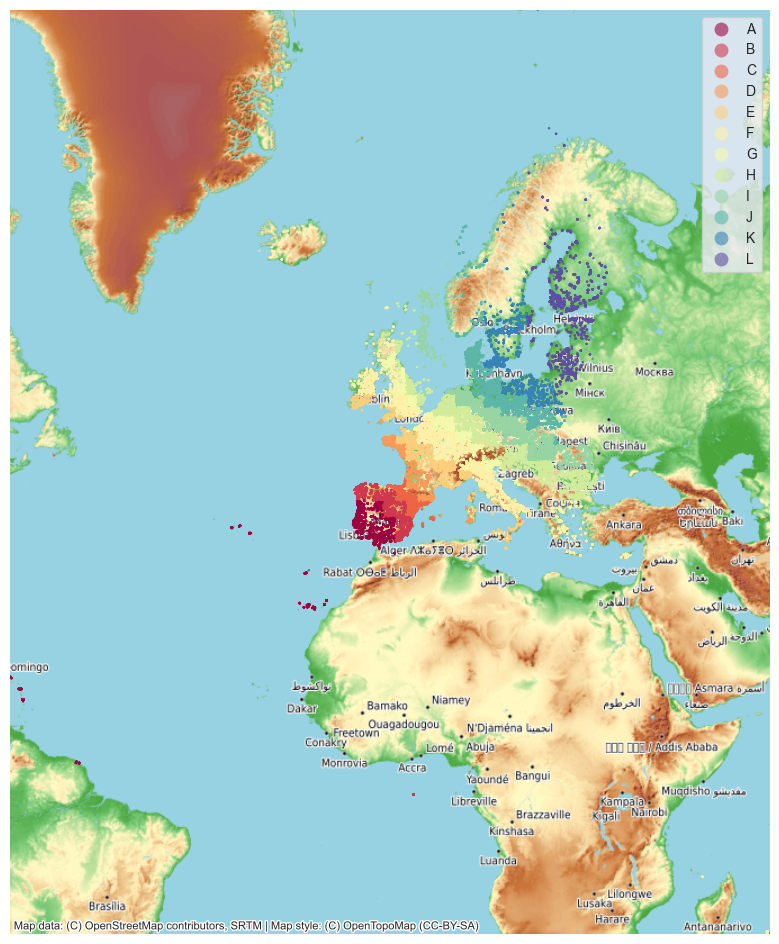

In [126]:
# pip install geopandas contextily

import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Créer un GeoDataFrame à partir de votre DataFrame
gdf = gpd.GeoDataFrame(df_agg_per_FacilityInspireID_per_year, geometry=gpd.points_from_xy(df_agg_per_FacilityInspireID_per_year.Longitude, df_agg_per_FacilityInspireID_per_year.Latitude))

# Définir le système de coordonnées (CRS) pour les coordonnées géographiques
gdf.set_crs(epsg=4326, inplace=True)  # EPSG:4326 est le code pour WGS84

# Conversion au système de coordonnées utilisé par contextily
gdf = gdf.to_crs(epsg=3857)  # EPSG:3857 est le système de coordonnées pour les tuiles web

# Tracer la carte
fig, ax = plt.subplots(figsize=(18, 12))
gdf.plot(ax=ax, column='average_label', categorical=True, legend=True, markersize=.5, cmap='Spectral', alpha=0.6)

# Ajouter une carte de base
ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)

# Ajuster les limites et le format
ax.set_axis_off()
ax.set_xlim(gdf.total_bounds[[0, 2]])
ax.set_ylim(gdf.total_bounds[[1, 3]])
plt.show()